In [1]:
#import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
#load the FER-2013 dataset
data_path = '/kaggle/input/fer2013'
train_dir = os.path.join(data_path, '/kaggle/input/fer2013/train')
test_dir = os.path.join(data_path, '/kaggle/input/fer2013/test')

In [3]:
img_shape = 48
batch_size = 64
train_data_path = '../input/fer2013/train/'
test_data_path = '../input/fer2013/test/'

In [4]:
# Define data augmentation parameters

train_datagen = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_datagen = ImageDataGenerator(
    rescale = 1 / 255.,
)



train_data = train_datagen.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


test_data = test_datagen.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
from keras.layers import BatchNormalization

def Create_CNN_Model():
    
    model = Sequential()
    
    #CNN1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN2
    model.add(Conv2D(64, (3,3), activation='relu', ))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    #CNN3
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))
    
    
    #Output
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7,activation='softmax'))
    
    
    return model

In [6]:
CNN_Model = Create_CNN_Model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                        

In [7]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [9]:
CNN_history = CNN_Model.fit( train_data , validation_data= test_data , epochs=15, batch_size= batch_size,
                            callbacks=callbacks, steps_per_epoch= steps_per_epoch, validation_steps=validation_steps)

Epoch 1/50
448/448 [==============================] - 176s 392ms/step - loss: 1.9429 - accuracy: 0.2250 - val_loss: 1.8260 - val_accuracy: 0.2553 - lr: 0.0010
Epoch 2/50
448/448 [==============================] - 64s 143ms/step - loss: 1.7774 - accuracy: 0.2763 - val_loss: 1.8727 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 3/50
448/448 [==============================] - 68s 152ms/step - loss: 1.6535 - accuracy: 0.3402 - val_loss: 1.5024 - val_accuracy: 0.4076 - lr: 0.0010
Epoch 4/50
448/448 [==============================] - 69s 155ms/step - loss: 1.5270 - accuracy: 0.4088 - val_loss: 1.5351 - val_accuracy: 0.4446 - lr: 0.0010
Epoch 5/50
448/448 [==============================] - 68s 152ms/step - loss: 1.4264 - accuracy: 0.4528 - val_loss: 1.3580 - val_accuracy: 0.4771 - lr: 0.0010
Epoch 6/50
448/448 [==============================] - 72s 161ms/step - loss: 1.8207 - accuracy: 0.2546 - val_loss: 2.0242 - val_accuracy: 0.1740 - lr: 0.0010
Epoch 7/50
448/448 [==============================]

KeyboardInterrupt: 

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))



In [ ]:
CNN_Score = CNN_Model.evaluate(train_data)

print("    Train Loss: {:.5f}".format(CNN_Score[0]))
print("Train Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

In [20]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
  
  #plt.tight_layout()

In [ ]:
plot_curves(CNN_history)

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

In [ ]:
test_data.class_indices

In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
# Print classification report and confusion matrix
print('Classification report:')
print(classification_report(test_data.labels, CNN_Predictions))

In [ ]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
CNN_Model.save("CNN_Model.h5")

# ResNet50V2 Model

In [10]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64
train_data_path = '/kaggle/input/fer2013/train'
test_data_path = '/kaggle/input/fer2013/test'

In [11]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
# Fine-Tuning ResNet50V2
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

#ResNet50V2.summary()

94668760/94668760 [==============================] - 4s 0us/step


In [13]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [14]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [15]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_13 (Bat  (None, 64)               256       
 chNormalization)                                     

In [16]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=15, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15
448/448 [==============================] - 411s 917ms/step - loss: 0.7459 - accuracy: 0.7309 - val_loss: 0.9402 - val_accuracy: 0.6759 - lr: 4.0000e-05
Epoch 2/15
448/448 [==============================] - 403s 899ms/step - loss: 0.7368 - accuracy: 0.7355 - val_loss: 0.9400 - val_accuracy: 0.6758 - lr: 4.0000e-05
Epoch 3/15
448/448 [==============================] - 420s 938ms/step - loss: 0.7310 - accuracy: 0.7394 - val_loss: 1.0136 - val_accuracy: 0.6766 - lr: 4.0000e-05
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.7393
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
448/448 [==============================] - 400s 892ms/step - loss: 0.7229 - accuracy: 0.7393 - val_loss: 0.9728 - val_accuracy: 0.6742 - lr: 4.0000e-05
Epoch 5/15
448/448 [==============================] - 406s 906ms/step - loss: 0.7099 - accuracy: 0.7457 - val_loss: 0.9558 - val_accuracy: 0.6773 - lr: 8.0000e-06
Epoch 6/15
448/448 [====

In [18]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 28s 248ms/step - loss: 0.9905 - accuracy: 0.6786
    Test Loss: 0.99054
Test Accuracy: 67.86%


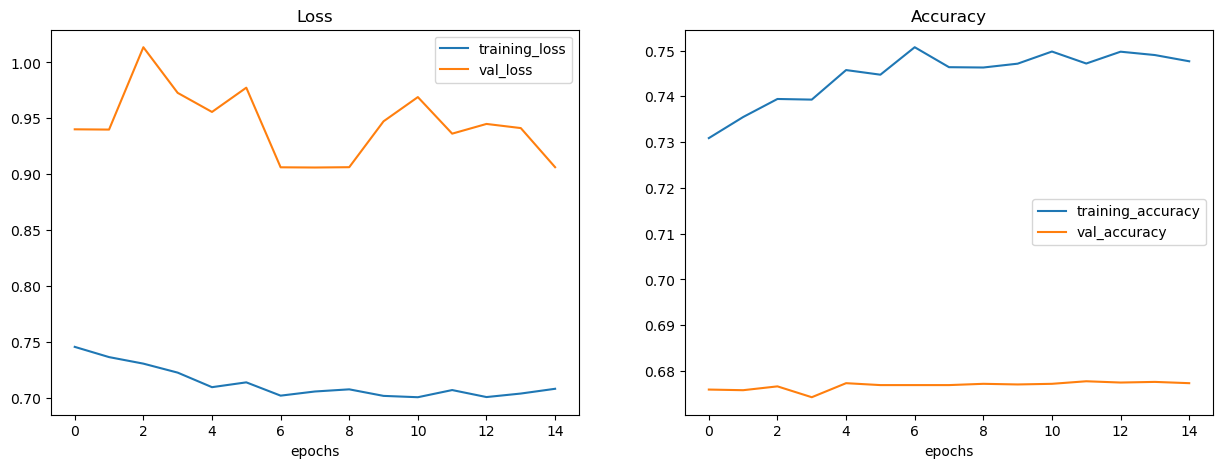

In [38]:
plot_curves(ResNet50V2_history)

In [39]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 33s 295ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

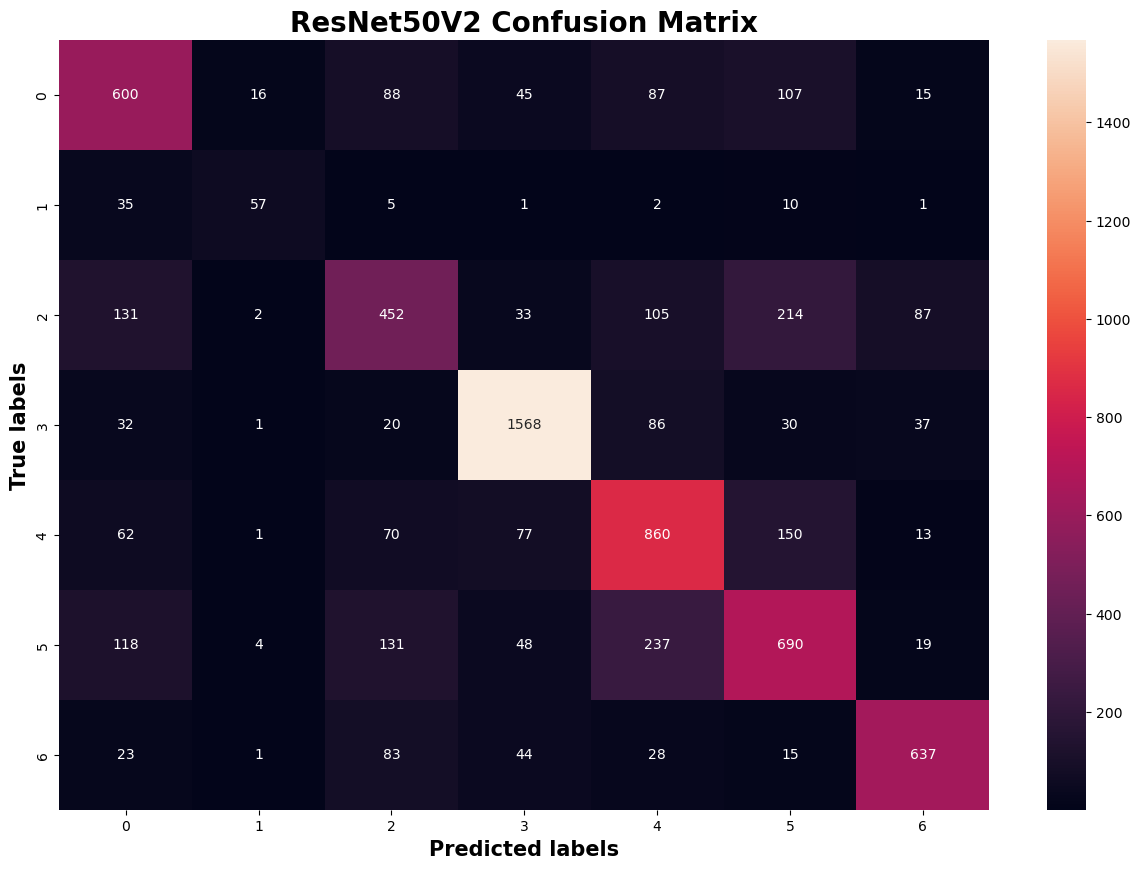

In [40]:
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

In [41]:
Emotion_Classes = ['Angry', 
                  'Disgust', 
                  'Fear', 
                  'Happy', 
                  'Neutral', 
                  'Sad', 
                  'Surprise']

In [42]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


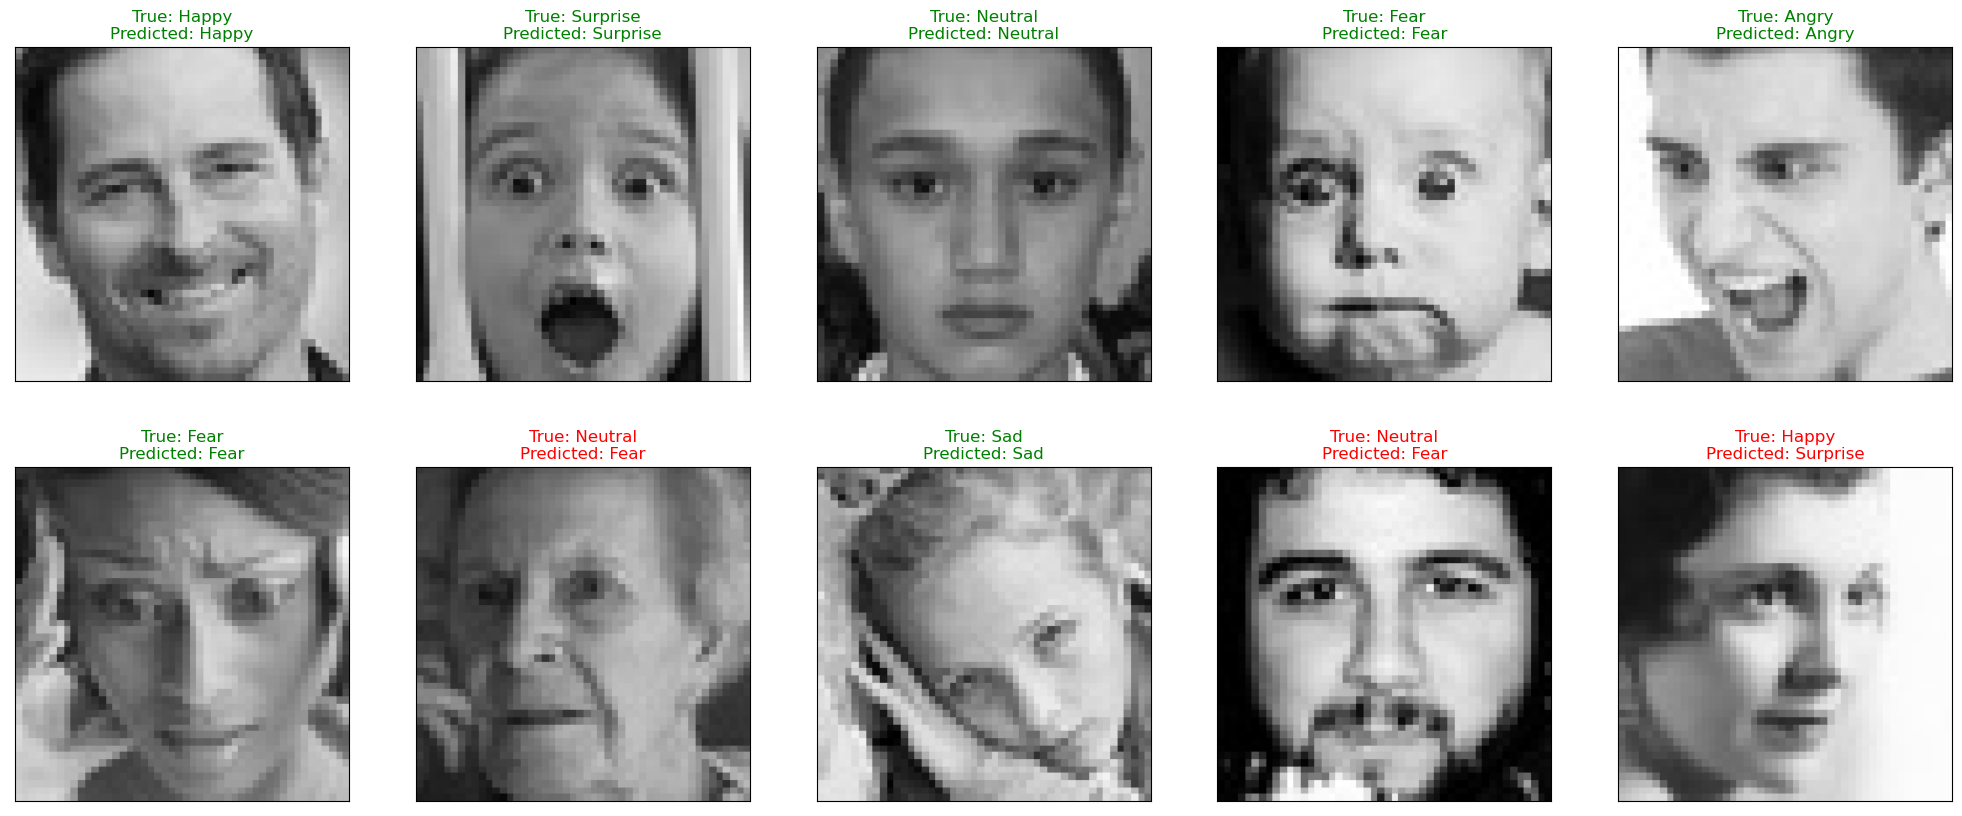

<Figure size 640x480 with 0 Axes>

In [43]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


In [44]:
ResNet50V2_Model.save("ResNet50V2_Model.h5")

# Music Generation

In [49]:
pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 62.2 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592305 sha256=17573aa9e44831e50da3f19c8a2ea9ab31ace76a915e62a6abaf067e8ae434fe
  Stored in directory: /root/.cache/pip/wheels/ea/8a/5a/615ed5b0cab54051df02fbaa4ad5334f91e3156b8c8753f5fc
Successfully built pretty_midi
Note: you may need to restart the kernel to use updated packages.


In [53]:
import os
import glob
import pretty_midi

data_folder = '/kaggle/input/classical-music-midi'
midi_files = glob.glob(os.path.join(data_folder, '*.mid'))

# Process MIDI files
for midi_file in midi_files:
    # Load MIDI file
    midi_data = pretty_midi.PrettyMIDI(midi_file)
    
    # Process MIDI data as desired
    # For example:
    # Get piano roll representation of MIDI data
    piano_roll = midi_data.get_piano_roll(fs=100)
    
    # Do something with the piano roll data
    # For example:
    # Normalize the piano roll data to be between 0 and 1
    piano_roll = piano_roll / 127.0
    
    # Save the processed data as desired


In [55]:
import os
import glob
import numpy as np
import pretty_midi

# Specify the path to the classical MIDI dataset
midi_dir = '/kaggle/input/classical-music-midi'

# Get a list of all the MIDI files in the dataset
midi_files = glob.glob(os.path.join(midi_dir, '*.mid'))

# Shuffle the list of MIDI files
np.random.shuffle(midi_files)

# Split the dataset into training and validation sets
split_ratio = 0.8
split_index = int(len(midi_files) * split_ratio)

train_files = midi_files[:split_index]
valid_files = midi_files[split_index:]


In [57]:
!pip install music21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 38.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 21.3 MB/s eta 0:00:00


In [58]:
import os
import music21

def get_notes(midi_file):
    """
    Convert MIDI file into a sequence of notes and chords
    
    Parameters:
    midi_file (str): path to the MIDI file
    
    Returns:
    notes (list): a list of music21.note.Note and music21.chord.Chord objects
    """
    
    notes = []
    
    # Load MIDI file into a stream object
    midi = music21.converter.parse(midi_file)
    
    # Get all the notes and chords from the MIDI file
    for element in midi.flat.notesAndRests:
        
        # Handle notes
        if isinstance(element, music21.note.Note):
            notes.append(str(element.pitch))
        
        # Handle chords
        elif isinstance(element, music21.chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))
            
    return notes


def preprocess_midi_dataset(midi_dir, save_dir):
    """
    Preprocess the MIDI dataset by converting the MIDI files into a sequence of notes and chords
    
    Parameters:
    midi_dir (str): path to the directory containing MIDI files
    save_dir (str): path to the directory where preprocessed data will be saved
    """
    
    # Create the save directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Get a list of all the MIDI files in the dataset
    midi_files = [os.path.join(midi_dir, f) for f in os.listdir(midi_dir) if f.endswith('.mid')]
    
    # Preprocess each MIDI file
    for i, midi_file in enumerate(midi_files):
        
        # Get the preprocessed notes
        notes = get_notes(midi_file)
        
        # Save the preprocessed notes to a file
        file_name = f'{i}.txt'
        save_path = os.path.join(save_dir, file_name)
        with open(save_path, 'w') as f:
            for note in notes:
                f.write(f'{note}\n')


In [60]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/ResNet50V2_Model.h5')


In [61]:
import numpy as np
import cv2
import pandas as pd

# Load FER-2013 dataset
fer_df = pd.read_csv('/kaggle/input/fer2013/train')

# Define emotion classes
emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Define desired image size for preprocessing
img_size = (48, 48)

# Initialize lists to store preprocessed data and emotion labels
preprocessed_data = []
emotion_labels = []

# Loop through each row in the FER-2013 dataset
for idx, row in fer_df.iterrows():
    # Extract the image and emotion label for the current row
    pixels = np.array(row['pixels'].split(), dtype=np.uint8).reshape(48, 48)
    emotion_label = emotion_classes.index(row['emotion'])
    
    # Only use data from the seven emotions we're interested in
    if emotion_label not in [0, 1, 2, 3, 4, 5, 6]:
        continue
    
    # Resize the image to the desired size
    resized_img = cv2.resize(pixels, img_size)
    
    # Normalize the pixel values to be between 0 and 1
    normalized_img = resized_img.astype('float32') / 255.0
    
    # Add the preprocessed image and emotion label to the lists
    preprocessed_data.append(normalized_img)
    emotion_labels.append(emotion_label)
    
# Convert lists to numpy arrays
preprocessed_data = np.array(preprocessed_data)
emotion_labels = np.array(emotion_labels)

# Save the preprocessed data and emotion labels as numpy arrays
np.save('preprocessed_data.npy', preprocessed_data)
np.save('emotion_labels.npy', emotion_labels)


IsADirectoryError: [Errno 21] Is a directory: '/kaggle/input/fer2013/train'

In [59]:
preprocessed_data = np.load('preprocessed_data.npy')
emotion_labels = np.load('emotion_labels.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'preprocessed_data.npy'